# Animal classification AI

## TOC
- Student info
- Important note
- Important note
- Special credits
- Required imports and basic setup
- Step 1: Loading the data
   - 1.a: Saving the labels
   - 1.b: Saving dictionary of file paths
- Step 2: Data analysis
   - 2.a: showing some images
- Step 3: Choosing the predictor
   - 3.a: Loading in the pickle data
   - 3.b: Encoding the images
   - 3.c: Validate loaded data
- Step 4: Making validation set(s) and test set(s)
- Step 5: Training and optimising model
   

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [2]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

In [3]:
# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## Step 1: Loading the data
Before we can start exploring our data and making models we have to setup everything that is needed to access the data.

The data is provided in the Kaggle compition and saved under a folder "test" and "train" inside the folder "images" which is saved in this files parent directory as set up in the previous basic setup step.

### 1.a: Saving the labels
The training data provided is saved inside a folder which name corresponds to the label of the data inside that folder. Thus getting the labels of the data is nothing more then getting all folder names inside the "train" folder.

In [4]:
train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))
amount_of_labels = label_strings.shape[0]

print("Amount of classes (labels): ", amount_of_labels)
print("\nLabels: ", label_strings)

Amount of classes (labels):  12

Labels:  ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


### 1.b: Saving dictionary of file paths
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Step 2: Data analysis
Before rigorously testing different models available it's important to take a look at the data that's supplied to us. This will not only validate the data is correctly loaded in the previous step but will also give us some hint as to what our data looks like, what it's distribution is...

This step can be done in a separate Jupyter Notebook "data_analysis" and thus the code is not repeated here, we do however print some of the images here to be sure the setup in the previous step succeeded

### 2.a: showing some images
In this step we'll display the first five images in the train set provided for the Kaggle compitition.

In [ ]:
fig, axes = plt.subplots(nrows=amount_of_labels, ncols=5, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:5]]

    for colidx in range(5):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 2: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

## Step 3: Choosing the predictor
From the information gathered in step 2, the preffered predictor and optimal amount of features is loaded.
These parameters require finetuning.

### 3.a: Loading in the pickle data

In [ ]:
# fine tune these parameters
descriptor_desired = 'sift'
amount_of_features_per_image = 100

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

# ----------------- get the wanted features ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_features_per_image)

### 3.b: Encoding the images

In [ ]:
# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
    
# ----------------- make labels numerical ----------------- 
train_labels_text = train_labels[:]

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

print(train_labels_text[:10])
print(train_labels[:10])
    
# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

### 3.c: Validate loaded data

In [ ]:
# ----------------- print some info ----------------- 
print("Amoount of points available: ", len(train_features_from_pkl[0][2]))
print("Amoount of points requested: ", len(train_data[0]))

print("\nTrain labels: ", train_labels[:2])
print("Train data: \n", train_data[:2])

print("\nTest data by Kaggle: \n", test_data_by_kaggle[:2])

## Step 4: Making validation set(s) and test set(s)
If we finetune hyperparameters based on the test data, the score on this part of the data will again not be representative anymore for the score on completely unseen data. Therefore, we can not do the hyperparameter selection based on the test data. This is why we need to split the training data a second time into a training set and a validation set.

Remember to take into account we're working with unbalanced data.

In [ ]:
# Split off a test set of approximatly 25% of the data
# random: train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)
# taking into account unbalance: train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, random_state=0)

#parameter to be finetuned
test_fraction = 0.25

train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

#validating the split
print("Train labels: ", train_labels_split[:2])
print("\nTrain data: \n", train_data_split[:2])

## Step 5: Training and optimising model
After all of this work we can finally start with training our model, checking it performance, and optimising it further.

### 5.a: Finetuning input
Documented in the report, section: Finetuning the input

In [7]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function, ignoring  annoying errors
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def try_different_feature_amounts(feature_amounts_to_test, descriptor_desired, test_fraction, iterations):
    #global vars
    train_scores = [0 for x in feature_amounts_to_test]
    test_scores = [0 for x in feature_amounts_to_test]

    for _ in range(iterations):
        for i in range(len(feature_amounts_to_test)):
            # ----------------- setup loop ----------------- 
            amount_of_features_per_image = feature_amounts_to_test[i]

            #edit to current model
            model = LogisticRegression()

            # ----------------- open pickle files ----------------- 
            with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
                train_features_from_pkl = pickle.load(pkl_file_train)

            with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
                test_features_from_pkl = pickle.load(pkl_file_test)

            # ----------------- get the wanted features ----------------- 
            clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_features_per_image)

            # ----------------- encode all train images ----------------- 
            train_data = []
            train_labels = []

            for image_features in train_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                train_data.append(bow_feature_vector)
                train_labels.append(image_features.label)

            # ----------------- make labels numerical ----------------- 
            train_labels_text = train_labels[:]

            label_encoder = sklearn.preprocessing.LabelEncoder()
            label_encoder.fit(label_strings)
            train_labels = label_encoder.transform(train_labels)

            # ----------------- encode all test images ----------------- 
            test_data_by_kaggle = []
            for image_features in test_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                test_data_by_kaggle.append(bow_feature_vector)

            # ----------------- making subsets ----------------- 
            train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            train_score = log_loss(train_labels_split, predictions_probability_train)
            test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ", i, " -> Accuracy of " + descriptor_desired + " driven model with ", amount_of_features_per_image, " features : ",train_score," (train), ",test_score," (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

#-------------------------

def try_different_inputs(feature_amounts_to_test, descriptors_to_test, test_fraction, iterations):
    result = [[descriptor_to_test, 0, 0] for descriptor_to_test in descriptors_to_test]
    for i in  range(len(descriptors_to_test)):
        train_scores, test_scores = try_different_feature_amounts(feature_amounts_to_test, descriptors_to_test[i], test_fraction, amount_of_averaging_iterations)
        result[i][1] = train_scores
        result[i][2] = test_scores
        
        #display graph from results
        x_axis = feature_amounts_to_test
        y_axis_train = train_scores
        y_axis_test = test_scores
        plt.plot(x_axis, y_axis_test,'b-', label="Test score", marker='o')
        plt.plot(x_axis, y_axis_train,'r-', label="Train score", marker='o')

        plt.xlabel('feature amount')
        plt.ylabel('score')
        plt.title('Score relative to feature amount - '+ descriptors_to_test[i])

        plt.legend(loc="upper left")
        plt.savefig("../graphs/2-LBM-feature_amount_" + descriptors_to_test[i] + ".png")

        plt.show()
        
    return result

    
#-------------------------

def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
#save to file example
#save_var_to_file("testabc", erdos_renye_network)
    
#open from file example
#from_file = get_var_from_file("testabc")




training took 4.988762617111206 seconds
Loop  0  -> Accuracy of daisy driven model with  5  features :  2.2230717806215767  (train),  2.2311030394283407  (test)
training took 2.1338164806365967 seconds
Loop  1  -> Accuracy of daisy driven model with  20  features :  1.9740116146192987  (train),  2.0171992353613564  (test)
training took 6.657189846038818 seconds
Loop  2  -> Accuracy of daisy driven model with  50  features :  1.7215177965581185  (train),  1.7538064178458126  (test)
training took 9.229048013687134 seconds
Loop  3  -> Accuracy of daisy driven model with  100  features :  1.5991645377533141  (train),  1.7152050354381072  (test)
training took 12.323991060256958 seconds
Loop  4  -> Accuracy of daisy driven model with  150  features :  1.5064770166160764  (train),  1.6359749023685897  (test)
training took 19.65080499649048 seconds
Loop  5  -> Accuracy of daisy driven model with  250  features :  1.416275698520221  (train),  1.5800766323284308  (test)
training took 44.51876807

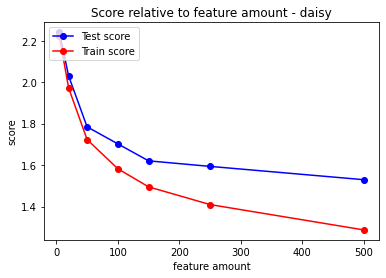

training took 8.012943267822266 seconds
Loop  0  -> Accuracy of orb driven model with  5  features :  2.2946598838301653  (train),  2.302474692942654  (test)
training took 8.6722252368927 seconds
Loop  1  -> Accuracy of orb driven model with  20  features :  2.122743135831336  (train),  2.171671220012355  (test)
training took 12.502204418182373 seconds
Loop  2  -> Accuracy of orb driven model with  50  features :  2.0254218206516503  (train),  2.0825867436375027  (test)
training took 15.898364782333374 seconds
Loop  3  -> Accuracy of orb driven model with  100  features :  1.9112062003313959  (train),  2.0434317378277655  (test)
training took 14.145915985107422 seconds
Loop  4  -> Accuracy of orb driven model with  150  features :  1.8789715713049642  (train),  1.9958479578950936  (test)
training took 20.395540475845337 seconds
Loop  5  -> Accuracy of orb driven model with  250  features :  1.7949117355530644  (train),  1.9957344054752015  (test)
training took 37.67120695114136 seconds

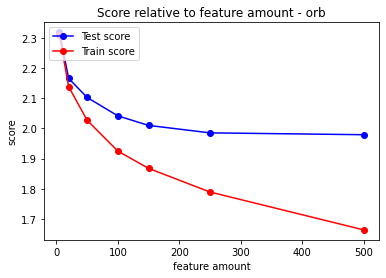

training took 3.9907538890838623 seconds
Loop  0  -> Accuracy of freak driven model with  5  features :  2.2613950120371062  (train),  2.2891080082624553  (test)
training took 6.611896991729736 seconds
Loop  1  -> Accuracy of freak driven model with  20  features :  2.0496606542558515  (train),  2.1249499981406466  (test)
training took 6.201005697250366 seconds
Loop  2  -> Accuracy of freak driven model with  50  features :  1.8134344278909478  (train),  1.9073791991065558  (test)
training took 6.846227169036865 seconds
Loop  3  -> Accuracy of freak driven model with  100  features :  1.632350922340207  (train),  1.7963785549782891  (test)
training took 9.492726802825928 seconds
Loop  4  -> Accuracy of freak driven model with  150  features :  1.55318535641005  (train),  1.732561436636038  (test)
training took 14.581448554992676 seconds
Loop  5  -> Accuracy of freak driven model with  250  features :  1.4385077421449197  (train),  1.686271317577142  (test)
training took 30.598988294601

In [ ]:
# Edit to your needs, by default there's a maximum of 500 features in the supplied pickle file
feature_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]
descriptors_to_test = ["daisy", "orb", "freak", "lucid", "vgg", "boost_desc", "sift"]
test_fraction = 0.25
amount_of_averaging_iterations = 5

result = try_different_inputs(feature_amounts_to_test, descriptors_to_test, test_fraction, amount_of_averaging_iterations)

#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_inputs", result)


### 5.x: Final model

In [ ]:
# step 1: import the model
from sklearn.linear_model import LogisticRegression

# step 2: create a model instance 
# (this is a model object that can be trained, tuned and used)

model = LogisticRegression()

# step 3: train the model on the training data

model.fit(train_data_split, train_labels_split)

# step 4: predict labels for test data 

predictions_train = model.predict(train_data_split)
predictions_probability_train = model.predict_proba(train_data_split)

predictions_test = model.predict(test_data_split)
predictions_probability_test = model.predict_proba(test_data_split)

# step 4: calculate the accuracy of the model on the train set and on the test set
# We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

train_score = log_loss(train_labels_split, predictions_probability_train)
test_score = log_loss(test_labels_split, predictions_probability_test)

print("Accuracy of model: ",train_score," (train), ",test_score," (test)")

## Step 6: Generating CSV for submission

In [ ]:
# Do predictions on the actual test data
predictions_probability_test_data_by_kaggle = model.predict_proba(test_data_by_kaggle)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('linear_baseline', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_test_data_by_kaggle, pred_file_path, label_strings)